## 1. Project Setup & Data Loading

This project uses the dataset from the Kaggle competition "NLP Getting Started" (Disaster Tweets). The data was previously downloaded as `nlp-getting-started.zip` and stored in Google Drive.

### Steps Completed:

1.  **Mount Google Drive:** We authenticated and mounted the user's Google Drive to the Colab environment using `from google.colab import drive`.
2.  **Create Local Directory:** A new directory was created at `/content/disaster_tweets_data/` to serve as a clean workspace for the dataset.
3.  **Unzip Data:** The `!unzip` command was used to extract the contents of `/content/drive/My Drive/nlp-getting-started.zip` directly into the `/content/disaster_tweets_data/` directory.
4.  **Verification:** We listed the contents of the target directory and confirmed that the following files are present and ready for analysis:
    * `train.csv`
    * `test.csv`
    * `sample_submission.csv`

In [2]:
from google.colab import drive
drive.mount('/content/drive')

# Create a directory to hold the data
!mkdir /content/disaster_tweets_data

# Unzip the file into the new directory
!unzip "/content/drive/My Drive/nlp-getting-started.zip" -d /content/disaster_tweets_data

!ls /content/disaster_tweets_data

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Archive:  /content/drive/My Drive/nlp-getting-started.zip
  inflating: /content/disaster_tweets_data/sample_submission.csv  
  inflating: /content/disaster_tweets_data/test.csv  
  inflating: /content/disaster_tweets_data/train.csv  
sample_submission.csv  test.csv  train.csv


## Step 1: Problem and Data Description

### The Problem

This project is a **binary text classification** challenge. The goal is to build a model that uses Natural Language Processing (NLP) to analyze a tweet's `text` and predict whether it is about a **real disaster** (classified as `1`) or **not** (classified as `0`).

NLP is a field of artificial intelligence that gives computers the ability to understand, interpret, and process human language.

### The Data

We are using three files provided by the Kaggle competition:
* `train.csv`: The dataset we will use to train our model. It includes the tweet text and the correct `target` label.
* `test.csv`: The dataset we will use to make our final predictions. It does not have a `target` column.
* `sample_submission.csv`: A file that shows the correct format for submitting our predictions.

Let's load the data and examine its size, dimension, and structure.

In [9]:
### insalling wordcloud
!pip install wordcloud

Data loaded successfully.

- Training Data Shape & Info -
Shape (Rows, Columns): (7613, 5)

Column Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB

- Test Data Shape & Info -
Shape (Rows, Columns): (3263, 4)

Column Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB

- Target 

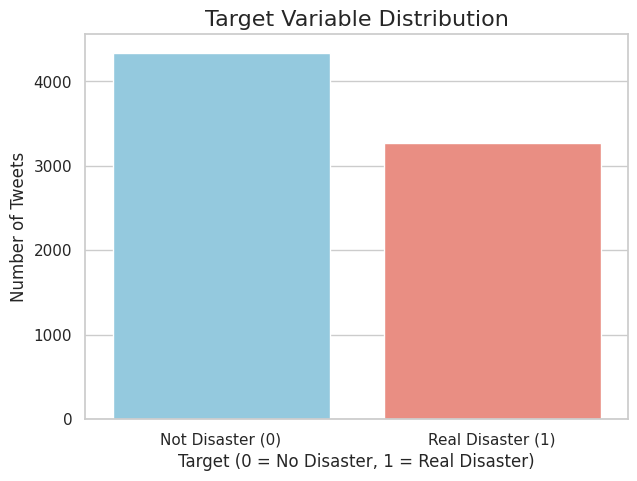

In [30]:
### installing libs

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string
import re
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, f1_score
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Bidirectional, LSTM, GRU, GlobalMaxPool1D, Dropout, Dense
import os
import requests
import zipfile
import io
import warnings
warnings.filterwarnings('ignore')

### set a visual style for plots
sns.set_theme(style="whitegrid")

### load data
### (we already unzipped this in the setup)
train_path = '/content/disaster_tweets_data/train.csv'
test_path = '/content/disaster_tweets_data/test.csv'

try:
    train_df = pd.read_csv(train_path)
    test_df = pd.read_csv(test_path)
    print("Data loaded successfully.")
except FileNotFoundError:
    print("Error: Files not found. Make sure the paths are correct.")
    ### stop execution if files aren't loaded
    raise

### describe training data
print("\n- Training Data Shape & Info -")
print(f"Shape (Rows, Columns): {train_df.shape}")
print("\nColumn Info:")
train_df.info()

### describe test data
print("\n- Test Data Shape & Info -")
print(f"Shape (Rows, Columns): {test_df.shape}")
print("\nColumn Info:")
test_df.info()

### describe target variable
print("\n- Target Variable Distribution (in train.csv) -")
target_counts = train_df['target'].value_counts()
print(f"Not Disaster (0): {target_counts[0]} tweets")
print(f"Real Disaster (1): {target_counts[1]} tweets")

### plot the target distribution
plt.figure(figsize=(7, 5))
ax = sns.barplot(x=target_counts.index, y=target_counts.values, palette=['skyblue', 'salmon'])
ax.set_title('Target Variable Distribution', fontsize=16)
ax.set_ylabel('Number of Tweets', fontsize=12)
ax.set_xlabel('Target (0 = No Disaster, 1 = Real Disaster)', fontsize=12)
ax.set_xticklabels(['Not Disaster (0)', 'Real Disaster (1)'])
plt.show()

## Step 2: Exploratory Data Analysis (EDA)

Now we will perform a deep dive into the data. A thorough EDA helps us understand data quality, find patterns, and make good decisions about data cleaning and feature engineering.

### Part 2.1: `keyword` and `location` Columns

We'll start by analyzing the "metadata" columns. Our main questions are:
1.  How much data is missing?
2.  If the data isn't missing, is it useful?
3.  Do any keywords or locations strongly correlate with a disaster?

--- EDA Part 2.1: keyword and location ---

Calculating missing values...


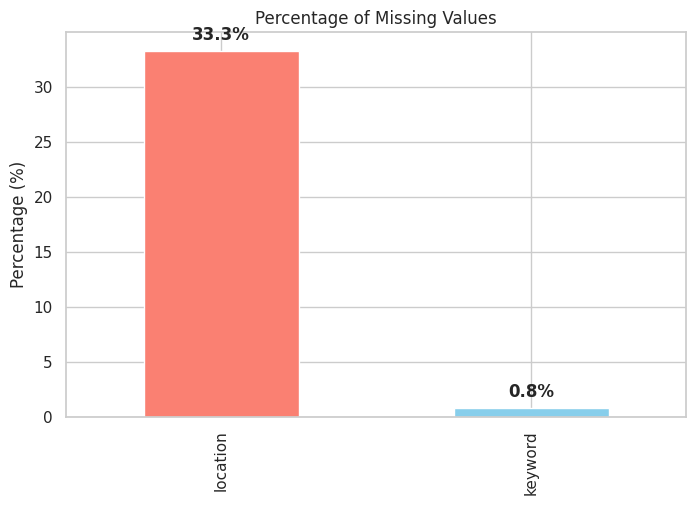


--- Analyzing 'keyword' Column ---
Top 20 most frequent keywords:
keyword
fatalities     45
deluge         42
armageddon     42
damage         41
body%20bags    41
harm           41
sinking        41
evacuate       40
outbreak       40
fear           40
siren          40
windstorm      40
collided       40
twister        40
hellfire       39
famine         39
flames         39
weapon         39
wreckage       39
sunk           39

Calculating 'disaster rate' for top keywords...


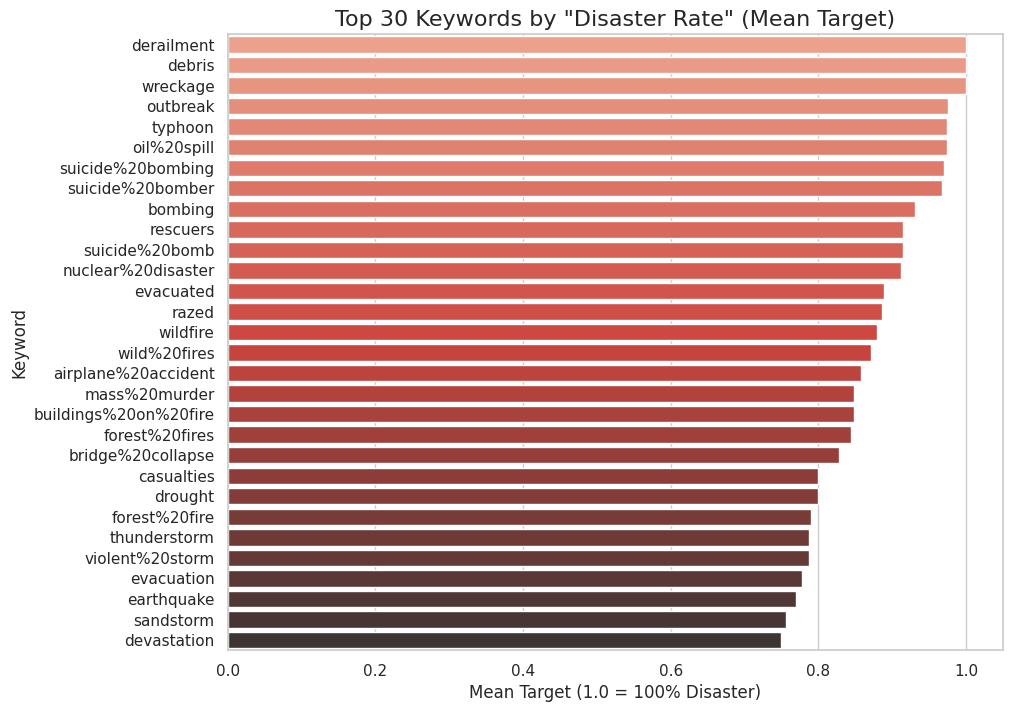


--- Analyzing 'location' Column ---
Top 30 most frequent 'location' entries:
location
USA                 104
New York             71
United States        50
London               45
Canada               29
Nigeria              28
UK                   27
Los Angeles, CA      26
India                24
Mumbai               22
Washington, DC       21
Kenya                20
Worldwide            19
Chicago, IL          18
Australia            18
California           17
New York, NY         15
California, USA      15
Everywhere           15
San Francisco        14
United Kingdom       14
Florida              14
Washington, D.C.     13
Los Angeles          13
Indonesia            13
NYC                  12
Toronto              12
Ireland              12
Chicago              11
Seattle              11


In [5]:
print("- EDA Part 2.1: keyword and location -")

### plot missing values
print("\nCalculating missing values...")

plt.figure(figsize=(10, 4))
missing_data = train_df.isnull().sum()
missing_data = missing_data[missing_data > 0] ### only show columns with missing data
missing_data.sort_values(ascending=False, inplace=True)

### calculate percentage
missing_percent = (missing_data / len(train_df)) * 100

### plotting
ax = missing_percent.plot(kind='bar', figsize=(8, 5),
                            title='Percentage of Missing Values',
                            ylabel='Percentage (%)',
                            color=['salmon', 'skyblue'])

### add percentage labels on top
for i, v in enumerate(missing_percent):
    ax.text(i, v + 1, f"{v:.1f}%", ha='center', fontweight='bold')

plt.show()


### analyze 'keyword' column ---
print(f"\n- Analyzing 'keyword' Column -")

### show top 20 keywords
top_keywords = train_df['keyword'].value_counts().head(20)
print(f"Top 20 most frequent keywords:\n{top_keywords.to_string()}")

### analyze 'keyword' by target ---
print("\nCalculating 'disaster rate' for top keywords...")
plt.figure(figsize=(10, 8))

### grouped by keyword and find the mean of the 'target' column.
### a mean of 1.0 means this keyword *only* appears in disaster tweets.
### amean of 0.0 means this keyword *only* appears in non-disaster tweets.
keyword_target_mean = train_df.groupby('keyword')['target'].mean().sort_values(ascending=False)

### plotting top 30 keywords by their disaster rate
top_disaster_keywords = keyword_target_mean.head(30)
sns.barplot(x=top_disaster_keywords.values, y=top_disaster_keywords.index, palette='Reds_d')
plt.title('Top 30 Keywords by "Disaster Rate" (Mean Target)', fontsize=16)
plt.xlabel('Mean Target (1.0 = 100% Disaster)', fontsize=12)
plt.ylabel('Keyword', fontsize=12)
plt.show()


### analyze 'location' Column
print(f"\n- Analyzing 'location' Column -")
# This column has > 2500 missing values.
# Let's see the most common entries.
top_locations = train_df['location'].value_counts().head(30)
print(f"Top 30 most frequent 'location' entries:\n{top_locations.to_string()}")

### Part 2.2: `text` Column Meta-Features

Now we'll analyze the `text` column, starting with its "meta-features"—characteristics about the text itself, not the words. We'll look for patterns in:

1.  **Text Length:** The total number of characters in the tweet.
2.  **Word Count:** The total number of words in the tweet.
3.  **Average Word Length:** The average length of the words in each tweet.

We want to see if real disaster tweets (`target=1`) have different characteristics than non-disaster tweets (`target=0`).

- EDA Part 2.2: Text Meta-Features -

Training data with new meta-features:


,text,text_length,word_count,avg_word_length,target
0,Our Deeds are the Reason of this #earthquake M...,69,13,5.307692,1
1,Forest fire near La Ronge Sask. Canada,38,7,5.428571,1
2,All residents asked to 'shelter in place' are ...,133,22,6.045454,1
3,"13,000 people receive #wildfires evacuation or...",65,8,8.124999,1
4,Just got sent this photo from Ruby #Alaska as ...,88,16,5.500000,1



Plotting distributions of meta-features...


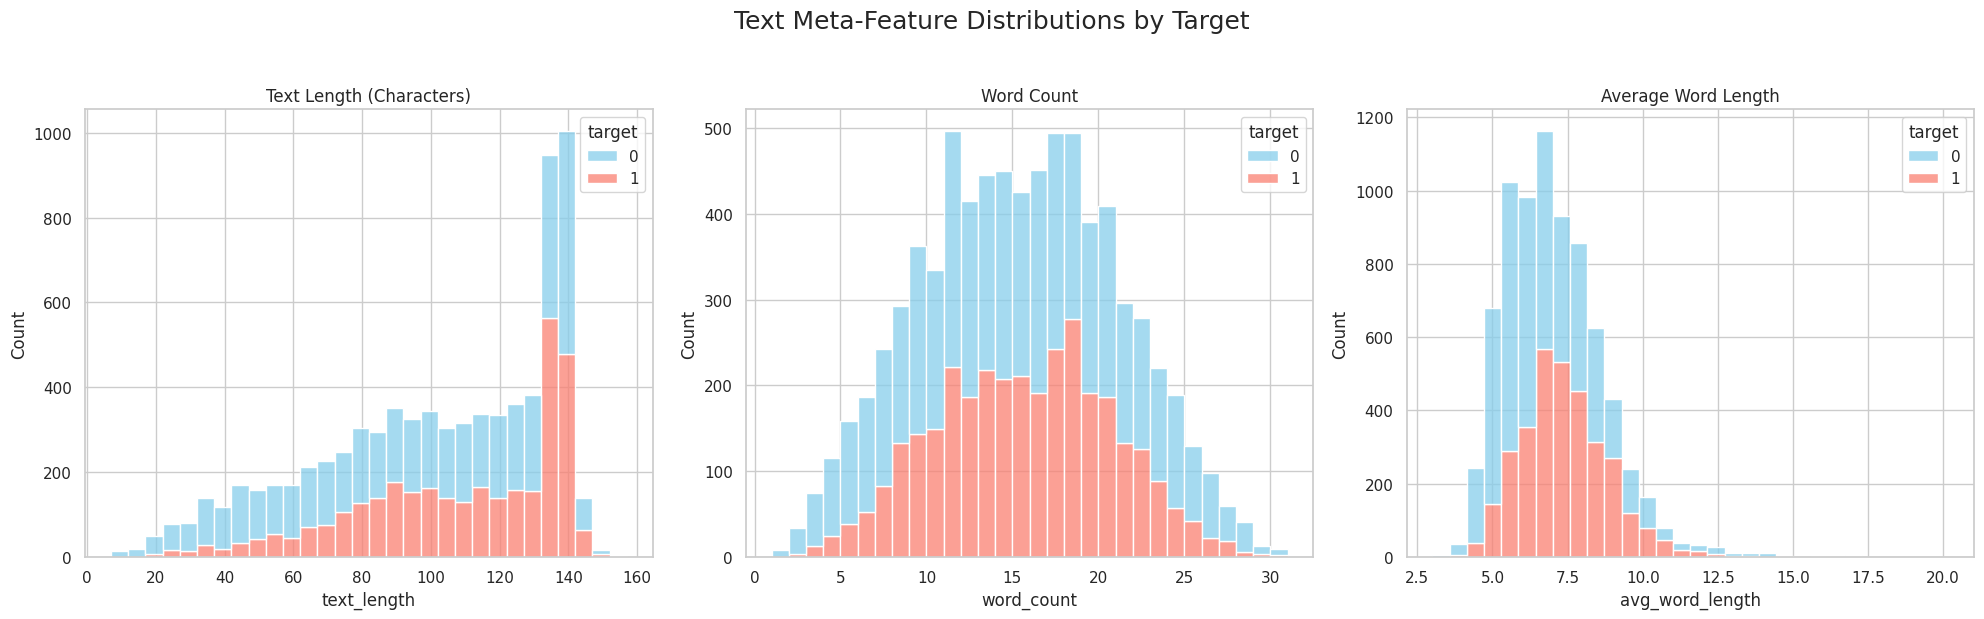

In [6]:
print("- EDA Part 2.2: Text Meta-Features -")

### create Meta-Features in train_df
### text length (character count)
train_df['text_length'] = train_df['text'].apply(len)

### word count (approximated by splitting on spaces)
train_df['word_count'] = train_df['text'].apply(lambda x: len(x.split()))

### average word length
train_df['avg_word_length'] = train_df['text_length'] / (train_df['word_count'] + 1e-6) ### add 1e-6 to avoid division by zero

### create Meta-Features in test_df
### apply the *same* feature engineering to our test set
test_df['text_length'] = test_df['text'].apply(len)
test_df['word_count'] = test_df['text'].apply(lambda x: len(x.split()))
test_df['avg_word_length'] = test_df['text_length'] / (test_df['word_count'] + 1e-6)

### display new features
print("\nTraining data with new meta-features:")
display(train_df[['text', 'text_length', 'word_count', 'avg_word_length', 'target']].head())


### plot distributions
print("\nPlotting distributions of meta-features...")
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
fig.suptitle('Text Meta-Feature Distributions by Target', fontsize=18, y=1.03)

### plot for text_length
sns.histplot(data=train_df, x='text_length', hue='target', multiple='stack',
             ax=axes[0], palette=['skyblue', 'salmon'], bins=30)
axes[0].set_title('Text Length (Characters)')

### plot for word_count
sns.histplot(data=train_df, x='word_count', hue='target', multiple='stack',
             ax=axes[1], palette=['skyblue', 'salmon'], bins=30)
axes[1].set_title('Word Count')

### plot for avg_word_length
sns.histplot(data=train_df, x='avg_word_length', hue='target', multiple='stack',
             ax=axes[2], palette=['skyblue', 'salmon'], bins=30)
axes[2].set_title('Average Word Length')

plt.tight_layout()
plt.show()

### Part 2.3: `text` Column Special Components

Tweets are not clean, formal sentences. They are full of special patterns like URLs, hashtags (`#`), mentions (`@`), and punctuation. We need to quantify these to decide how to handle them during our data cleaning phase.

We will create new features to count:
1.  **URLs:** (e.g., `http://...` or `https://...`)
2.  **Hashtags:** (e.g., `#disaster`)
3.  **Mentions:** (e.g., `@username`)
4.  **Punctuation:** (e.g., `!`, `?`, `.`)

- EDA Part 2.3: Text Special Components -

Training data with new special component features:


,text,url_count,hashtag_count,mention_count,punctuation_count,target
0,Our Deeds are the Reason of this #earthquake M...,0,1,0,1,1
1,Forest fire near La Ronge Sask. Canada,0,0,0,1,1
2,All residents asked to 'shelter in place' are ...,0,0,0,3,1
3,"13,000 people receive #wildfires evacuation or...",0,1,0,2,1
4,Just got sent this photo from Ruby #Alaska as ...,0,2,0,2,1



- Average Component Counts by Target -


,url_count,hashtag_count,mention_count,punctuation_count
target,,,,
0,0.507370,0.388761,0.420313,6.309074
1,0.769795,0.501987,0.272088,7.543565


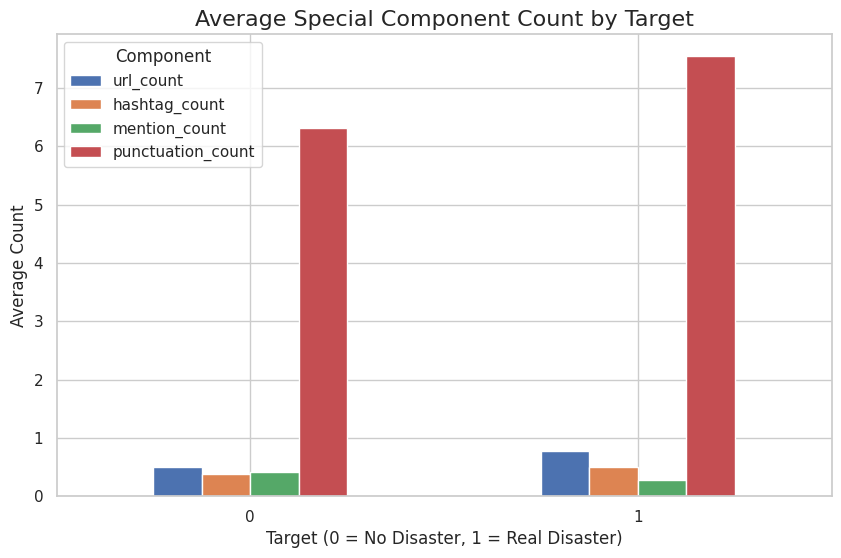

In [8]:
print("- EDA Part 2.3: Text Special Components -")

### define counting functions

def count_urls(text):
    ### Regex to find URLs
    return len(re.findall(r'https?://\S+', text))

def count_hashtags(text):
    ### Regex to find hashtags
    return len(re.findall(r'#\w+', text))

def count_mentions(text):
    ### Regex to find mentions
    return len(re.findall(r'@\w+', text))

def count_punctuation(text):
    ### count characters that are in the string.punctuation set
    return sum(1 for char in text if char in string.punctuation)

### apply to train_df
train_df['url_count'] = train_df['text'].apply(count_urls)
train_df['hashtag_count'] = train_df['text'].apply(count_hashtags)
train_df['mention_count'] = train_df['text'].apply(count_mentions)
train_df['punctuation_count'] = train_df['text'].apply(count_punctuation)

### apply to test_df (important for consistency) ---
test_df['url_count'] = test_df['text'].apply(count_urls)
test_df['hashtag_count'] = test_df['text'].apply(count_hashtags)
test_df['mention_count'] = test_df['text'].apply(count_mentions)
test_df['punctuation_count'] = test_df['text'].apply(count_punctuation)

### display a sample
print("\nTraining data with new special component features:")
display(train_df[['text', 'url_count', 'hashtag_count', 'mention_count', 'punctuation_count', 'target']].head())

### analyze the counts by target
print("\n- Average Component Counts by Target -")

### group by target and get the mean of our new columns
special_counts_mean = train_df.groupby('target')[['url_count', 'hashtag_count', 'mention_count', 'punctuation_count']].mean()
display(special_counts_mean)

### plotting these averages
special_counts_mean.plot(kind='bar', figsize=(10, 6), rot=0)
plt.title('Average Special Component Count by Target', fontsize=16)
plt.xlabel('Target (0 = No Disaster, 1 = Real Disaster)', fontsize=12)
plt.ylabel('Average Count', fontsize=12)
plt.legend(title='Component')
plt.show()

### Part 2.4: `text` Column Content Analysis (Word Clouds & N-grams)

This is the final and most important part of our EDA. We will now apply our cleaning decisions and analyze the *content* of the tweets.

**Our Cleaning Strategy (Recap):**
1.  Remove all URLs.
2.  Remove all user mentions (`@username`).
3.  Remove the `#` symbol from hashtags but keep the word.
4.  Convert all text to lowercase.
5.  Remove all punctuation.
6.  Remove common "stopwords" (like 'the', 'a', 'is') which add little meaning.

After cleaning, we will visualize the most common words and phrases (N-grams) for both disaster and non-disaster tweets to see the differences.


- EDA Part 2.4: Text Content Analysis -
Cleaning text data... This may take a moment.
Text cleaning complete.

Sample of original vs. cleaned text:


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,text,cleaned_text
0,Our Deeds are the Reason of this #earthquake M...,deeds reason earthquake may allah forgive us
1,Forest fire near La Ronge Sask. Canada,forest fire near la ronge sask canada
2,All residents asked to 'shelter in place' are ...,residents asked shelter place notified officer...
3,"13,000 people receive #wildfires evacuation or...",people receive wildfires evacuation orders cal...
4,Just got sent this photo from Ruby #Alaska as ...,got sent photo ruby alaska smoke wildfires pou...



Generating Word Clouds...


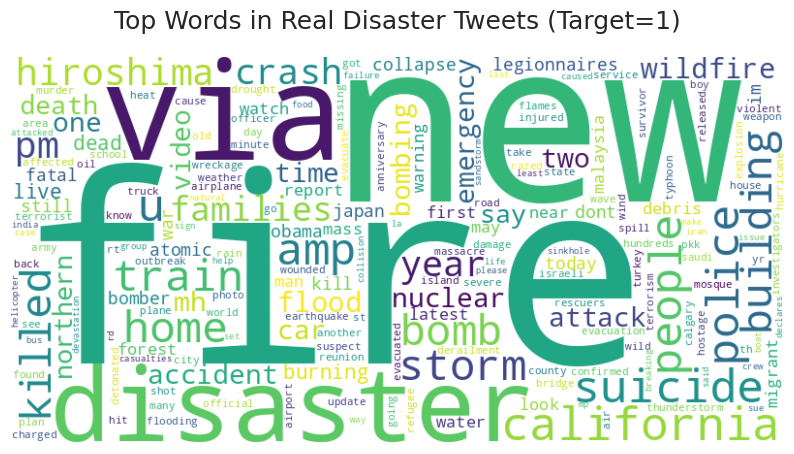

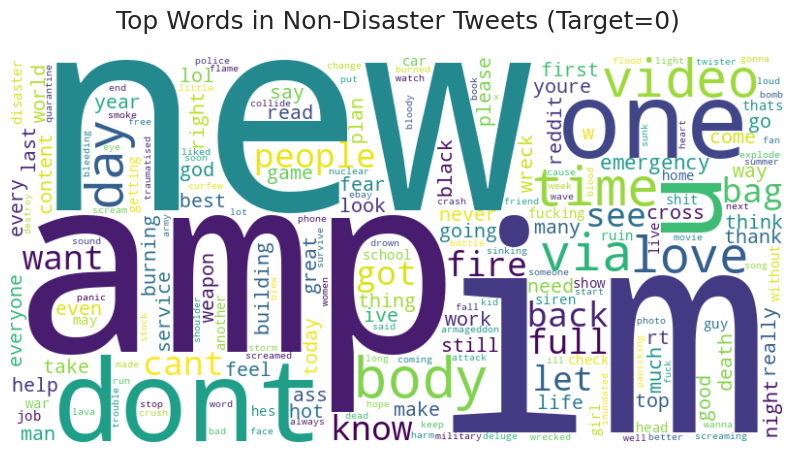

In [18]:
### download the stopwords list
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

print("\n- EDA Part 2.4: Text Content Analysis -")

### define the master cleaning function
def clean_text(text):
    ### remove URLs
    text = re.sub(r'https?://\S+', '', text)

    ### remove user mentions
    text = re.sub(r'@\w+', '', text)

    ### remove '#' from hashtags
    text = re.sub(r'#', '', text)

    ### convert to lowercase
    text = text.lower()

    ### remove punctuation
    ### use regex to keep only letters and spaces
    text = re.sub(r'[^a-z\s]', '', text)

    ### remove stopwords
    words = text.split()
    cleaned_words = [word for word in words if word not in stop_words]

    return " ".join(cleaned_words)

### apply the cleaning function
print("Cleaning text data... This may take a moment.")
### create a new column to hold the clean text
train_df['cleaned_text'] = train_df['text'].apply(clean_text)
### also applied this to the test data
test_df['cleaned_text'] = test_df['text'].apply(clean_text)

print("Text cleaning complete.")
print("\nSample of original vs. cleaned text:")
display(train_df[['text', 'cleaned_text']].head())


### define Word Cloud plotting function
def show_wordcloud(data_frame, target_value, title):
    ### filter text for the given target
    text = " ".join(review for review in data_frame[data_frame['target'] == target_value]['cleaned_text'])

    if len(text) == 0:
        print(f"No text data for target {target_value}")
        return

    wordcloud = WordCloud(width=800, height=400,
                          background_color='white',
                          collocations=False ### avoid showing "new york" as one word
                         ).generate(text)

    plt.figure(figsize=(10, 7))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title, fontsize=18, pad=20)
    plt.axis('off')
    plt.show()

### plot word clouds
print("\nGenerating Word Clouds...")

### word Cloud for REAL DISASTER tweets (target=1)
show_wordcloud(train_df, 1, 'Top Words in Real Disaster Tweets (Target=1)')

### word Cloud for NON-DISASTER tweets (target=0)
show_wordcloud(train_df, 0, 'Top Words in Non-Disaster Tweets (Target=0)')

## Step 3: Model Architecture

Before building a complex neural network, we will create a simple, fast, and highly effective **baseline model**. This gives us a crucial performance score (an F1-score) that our advanced model must beat.

For our baseline, we will use two classic NLP techniques:

1.  **TF-IDF (Term Frequency-Inverse Document Frequency):** This will convert our `cleaned_text` into a numerical matrix. Instead of just counting words, it creates a score for each word based on how *important* it is to a specific tweet (i.e., common in that tweet, but rare in all other tweets).
2.  **Logistic Regression:** A simple, fast, and powerful linear model that is excellent for binary classification tasks.

**The Process:**
1.  We will split our `train_df` into a new, smaller training set (80%) and a validation set (20%).
2.  We will `fit` the TF-IDF vectorizer on the 80% training data.
3.  We will `transform` both the 80% training and 20% validation data.
4.  We will train the Logistic Regression model on the 80% set.
5.  We will evaluate its performance on the 20% validation set (which it has never seen before).

In [19]:
print("- Step 3: Baseline Model (TF-IDF + Logistic Regression) -")

### define X (features) and y (target) ---
### use the 'cleaned_text' created in the EDA
X = train_df['cleaned_text']
y = train_df['target']

### split the data into training and validation sets
### create an 80/20 split to evaluate our model
### random_state=42 ensures we get the same split every time
X_train, X_val, y_train, y_val = train_test_split(X, y,
                                                  test_size=0.2,
                                                  random_state=42)

print(f"Training set size: {len(X_train)} samples")
print(f"Validation set size: {len(X_val)} samples")

### set up the TF-IDF Vectorizer ---
### limit to the top 5000 most frequent words
tfidf_vectorizer = TfidfVectorizer(max_features=5000)

### fit the vectorizer *only* on the training data
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)

### transform the validation data using the *same* fitted vectorizer
X_val_tfidf = tfidf_vectorizer.transform(X_val)

### set up and train the logistic regression model
### max_iter=1000 ensures the model has enough time to converge
baseline_model = LogisticRegression(max_iter=1000, random_state=42)

print("\nTraining the baseline model...")
baseline_model.fit(X_train_tfidf, y_train)
print("Training complete.")

### evaluate the model
print("\n- Baseline Model Validation Results -")
### make predictions on the validation set
y_pred_val = baseline_model.predict(X_val_tfidf)

### calc metrics
accuracy = accuracy_score(y_val, y_pred_val)
f1 = f1_score(y_val, y_pred_val, average='weighted') ### 'weighted' accounts for class balance

print(f"Validation Accuracy: {accuracy:.4f}")
print(f"Validation F1-Score (Weighted): {f1:.4f}")

### print the detailed report
print("\nFull Classification Report:")
report = classification_report(y_val, y_pred_val, target_names=['Not Disaster (0)', 'Real Disaster (1)'])
print(report)

- Step 3: Baseline Model (TF-IDF + Logistic Regression) -
Training set size: 6090 samples
Validation set size: 1523 samples

Training the baseline model...
Training complete.

- Baseline Model Validation Results -
Validation Accuracy: 0.8004
Validation F1-Score (Weighted): 0.7974

Full Classification Report:
                   precision    recall  f1-score   support

 Not Disaster (0)       0.79      0.88      0.84       874
Real Disaster (1)       0.82      0.69      0.75       649

         accuracy                           0.80      1523
        macro avg       0.80      0.79      0.79      1523
     weighted avg       0.80      0.80      0.80      1523



## Step 3 (Part B): Advanced Model (RNN) Data Preparation

Our baseline TF-IDF model is fast, but it has a major weakness: it ignores word order and context. The phrases "fire is on" and "on fire" are treated identically.

To capture this sequential information, we will build a **Recurrent Neural Network (RNN)**.

First, we must prepare our text data for the RNN using two critical steps:
1.  **Tokenization:** We use a Keras `Tokenizer` to build a vocabulary of our most common words. It converts each word into a unique integer. (e.g., "fire" -> 21, "storm" -> 55).
2.  **Padding:** Neural networks require inputs of a fixed, uniform length. We will use `pad_sequences` to ensure every tweet sequence has the same length (e.g., 25 tokens). Shorter tweets are padded with zeros, and longer ones are truncated.

In [20]:
print("- Step 3 (Part B): RNN Data Preparation -")

### define tokenizer hyperparameters
### build the vocabulary from the top 10,000 words
VOCAB_SIZE = 10000
### inspect the text length to pick a good padding length.
### from the EDA, most tweets are < 25 words.
MAX_LENGTH = 25
### this is a special token for words not in  vocab
OOV_TOKEN = "<OOV>"

### initialize and fit the tokenizer
### only fit the tokenizer on the *training data*
tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token=OOV_TOKEN)
tokenizer.fit_on_texts(X_train)

### tokenize (text to sequences)
print("Tokenizing text...")
### convert training and validation text to sequences of numbers
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_val)

### also need to process the final 'test_df' data for submission later
### (Using the same tokenizer)
X_test_seq = tokenizer.texts_to_sequences(test_df['cleaned_text'])

### pad the sequences
print("Padding sequences...")
### pad the training sequences
X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_LENGTH,
                            padding='post', truncating='post')

### pad the validation sequences
X_val_pad = pad_sequences(X_val_seq, maxlen=MAX_LENGTH,
                          padding='post', truncating='post')

### pad the final test sequences
X_test_pad = pad_sequences(X_test_seq, maxlen=MAX_LENGTH,
                           padding='post', truncating='post')

### inspect the results
print("\n- Data Preparation Complete -")
print(f"Vocabulary size: {len(tokenizer.word_index)}")
print(f"Shape of X_train (padded): {X_train_pad.shape}")
print(f"Shape of X_val (padded): {X_val_pad.shape}")
print(f"Shape of X_test (padded): {X_test_pad.shape}")

print("\nExample of original text:")
print(f"Text: '{X_train.iloc[0]}'")
print("\nAfter tokenizing and padding:")
print(X_train_pad[0])

### also need our labels (y_train, y_val) as NumPy arrays for TensorFlow
y_train_np = np.array(y_train)
y_val_np = np.array(y_val)

- Step 3 (Part B): RNN Data Preparation -
Tokenizing text...
Padding sequences...

- Data Preparation Complete -
Vocabulary size: 12783
Shape of X_train (padded): (6090, 25)
Shape of X_val (padded): (1523, 25)
Shape of X_test (padded): (3263, 25)

Example of original text:
Text: 'courageous honest analysis need use atomic bomb hiroshima japanese military refused surrender'

After tokenizing and padding:
[5307 3540 2191   77  334  122   48   50 1001  148 3541 3542    0    0
    0    0    0    0    0    0    0    0    0    0    0]


## Step 3 (Part C): Advanced Model - Architecture & Embeddings

We are now building our sequential model. A key component of this is the **Embedding Layer**.

This layer's job is to map our number sequences (like `[5307, 3540]`) to high-dimensional vectors (e.g., a 100-number array) that capture *semantic meaning*.

**Option 1 (Worse):** Train an embedding from scratch. The model starts with random vectors and learns the meaning of words *only* from our 7,613 tweets. This is difficult and data-intensive.

**Option 2 (Better):** Use **Pre-trained Embeddings**. We will use **"GloVe" (Global Vectors for Word Representation)**. This is a massive "dictionary" trained on billions of words from across the internet. It already understands that "fire" is closer to "hot" than it is to "water."

By using GloVe, we are giving our model a huge head-start and a deep understanding of language before it ever sees our data.

**Our Plan:**
1.  Download the 100-dimension GloVe file (`glove.6B.100d.txt`).
2.  Create an "embedding matrix" that maps *our* vocabulary (the 10,000 words from our Tokenizer) to their corresponding 100-dimension GloVe vectors.
3.  Feed this matrix into our model's `Embedding` layer.

In [22]:
print("- Step 3 (Part C): Preparing GloVe Embeddings -")

### download GloVe Embeddings
### use the 100-dimension version
GLOVE_URL = "http://nlp.stanford.edu/data/glove.6B.zip"
GLOVE_FILE = "glove.6B.100d.txt"
EMBEDDING_DIM = 100 # tis must match the file we use

### check if the file already exists
if not os.path.exists(GLOVE_FILE):
    print("GloVe file not found. Downloading...")
    try:
        r = requests.get(GLOVE_URL, stream=True)
        z = zipfile.ZipFile(io.BytesIO(r.content))
        ### extract only the 100d file we need
        z.extract(GLOVE_FILE)
        print(f"Successfully downloaded and extracted {GLOVE_FILE}")
    except Exception as e:
        print(f"Error downloading or extracting file: {e}")
        ### handle error
else:
    print("GloVe file already found locally.")

### load GloVe embeddings into a dictionary
print(f"Loading {GLOVE_FILE} into memory...")
embeddings_index = {}
try:
    with open(GLOVE_FILE, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = vector
    print(f"Loaded {len(embeddings_index)} word vectors.")
except FileNotFoundError:
    print(f"Error: {GLOVE_FILE} not found. Please re-run the download.")
    ### handle error

### create our embedding matrix
### use the tokenizer's word_index
### set VOCAB_SIZE = 10000 earlier
### need +1 because index 0 is reserved for padding
num_words = min(VOCAB_SIZE, len(tokenizer.word_index) + 1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))

### loop through our vocabulary and populate the matrix
words_found = 0
for word, i in tokenizer.word_index.items():
    if i >= VOCAB_SIZE:
        continue  ### skip words beyond our vocab limit

    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        ### words found in GloVe will be added
        embedding_matrix[i] = embedding_vector
        words_found += 1
    ### words not found in GloVe will remain all-zeros

print("\n- Embedding Matrix Complete -")
print(f"Shape of embedding matrix: {embedding_matrix.shape}")
print(f"Found {words_found} / {num_words-1} words from our vocab in GloVe.")

- Step 3 (Part C): Preparing GloVe Embeddings -
GloVe file not found. Downloading...
Successfully downloaded and extracted glove.6B.100d.txt
Loading glove.6B.100d.txt into memory...
Loaded 400000 word vectors.

- Embedding Matrix Complete -
Shape of embedding matrix: (10000, 100)
Found 8469 / 9999 words from our vocab in GloVe.


## Step 3 (Part D): Building & Training the RNN Model

Now we will define our model architecture. Our plan, as discussed, is to use a sequential model that can read the text in order to understand its context.

**Our Model Architecture:**
1.  **Input Layer:** A simple input that expects our padded sequences of `MAX_LENGTH` (25).
2.  **Embedding Layer:** This is where we load our pre-trained `embedding_matrix`. We set `trainable=False` so the model *uses* the GloVe meanings but doesn't *change* them during training. This saves compute time and prevents the model from "forgetting" the pre-trained knowledge.
3.  **Bidirectional LSTM Layer:** This is the "brain" of our model.
    * **LSTM** (Long Short-Term Memory): A special type of RNN that is very good at remembering important information over long sequences (its "long-term memory").
    * **Bidirectional:** We are wrapping the LSTM in this layer, which runs two LSTMs at once—one reading the tweet from left-to-right, and another from right-to-left. This gives the model a complete context (e.g., it knows what word came *before* and *after* "fire") before making a decision.
4.  **GlobalMaxPool1D Layer:** This layer simply "pools" the output of the LSTM and finds the *most important signal* from the entire sequence.
5.  **Dropout Layer:** A standard regularization technique. It randomly "turns off" 20% of the neurons during training to prevent the model from "memorizing" the training data (overfitting).
6.  **Output (Dense) Layer:** A final single neuron with a **sigmoid** activation. This will output a single probability between 0.0 (Not Disaster) and 1.0 (Real Disaster).

We will then compile this model and train it for 10 epochs.

- Step 3 (Part D): Building & Training the RNN Model -


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 25)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_2 (Embedding)         │ (None, 25, 100)        │     1,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 25, 128)        │        84,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_2          │ (None, 128)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,084,609 (4.14 MB)

 Trainable params: 84,609 (330.50 KB)

 Non-trainable params: 1,000,000 (3.81 MB)


- Applying shape fix for F1-Score metric -

- Training the RNN Model -
Epoch 1/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.7052 - f1_score: 0.6368 - loss: 0.5684 - val_accuracy: 0.8096 - val_f1_score: 0.7635 - val_loss: 0.4412
Epoch 2/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - accuracy: 0.8051 - f1_score: 0.7577 - loss: 0.4435 - val_accuracy: 0.7971 - val_f1_score: 0.7234 - val_loss: 0.4459
Epoch 3/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - accuracy: 0.8229 - f1_score: 0.7700 - loss: 0.4217 - val_accuracy: 0.8122 - val_f1_score: 0.7547 - val_loss: 0.4333
Epoch 4/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - accuracy: 0.8278 - f1_score: 0.7872 - loss: 0.3957 - val_accuracy: 0.7978 - val_f1_score: 0.7265 - val_loss: 0.4417
Epoch 5/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 8s 41ms/step - accuracy: 0.8300 - f1_score: 0.7874 - loss: 0.3886 - val_accuracy: 0.7958 - val_f1_score: 0.7591 - val_loss: 0.4560
Epoch 6/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - accuracy: 0.8458 

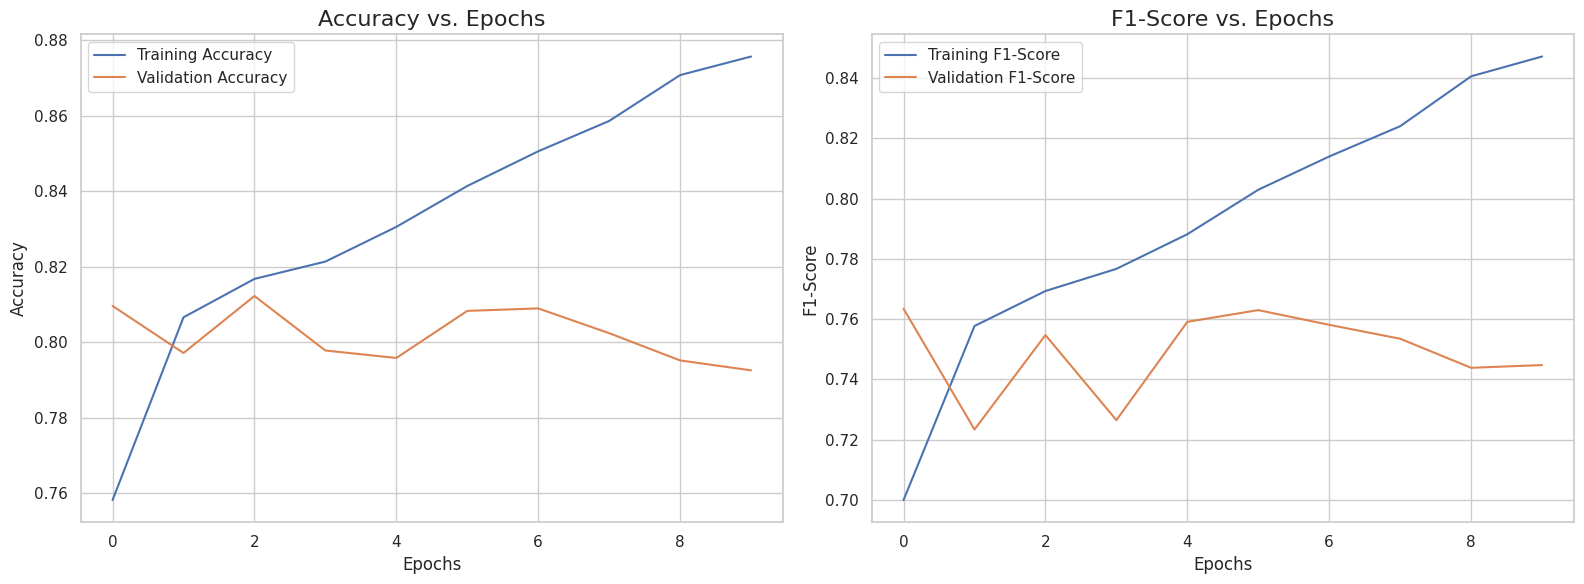

In [26]:
print("- Step 3 (Part D): Building & Training the RNN Model -")

### define the model architecture
### input layer
inputs = Input(shape=(MAX_LENGTH,))

### embedding layer (using our pre-built matrix)
embedding_layer = Embedding(input_dim=num_words,         ### from Part C (e.g., 10000)
                            output_dim=EMBEDDING_DIM,    ### from Part C (e.g., 100)
                            weights=[embedding_matrix],  ### GloVe matrix
                            input_length=MAX_LENGTH,
                            trainable=False)             ### freeze the embeddings
x = embedding_layer(inputs)

### bidirectional-LSTM layer
### use 64 units, and return_sequences=True to feed the full output to the next layer
x = Bidirectional(LSTM(64, return_sequences=True))(x)

### pooling layer
x = GlobalMaxPool1D()(x)

### dropout layer for regularization
x = Dropout(0.5)(x)

### output layer
outputs = Dense(1, activation='sigmoid')(x) ### sigmoid for binary classification

### create the model
rnn_model_1 = Model(inputs=inputs, outputs=outputs)

### compile the model
rnn_model_1.compile(optimizer='adam',                   ### adam default
                    loss='binary_crossentropy',       ### standard for 0/1 classification
                    metrics=['accuracy', tf.keras.metrics.F1Score(name='f1_score', threshold=0.5)])

rnn_model_1.summary() ### print a summary of the architecture

print("\n- Applying shape fix for F1-Score metric -")
### check if arrays are already 2D (in case cell is re-run)
if y_train_np.ndim == 1:
    y_train_np = y_train_np.reshape(-1, 1)
    print(f"Reshaped y_train_np to: {y_train_np.shape}")
if y_val_np.ndim == 1:
    y_val_np = y_val_np.reshape(-1, 1)
    print(f"Reshaped y_val_np to: {y_val_np.shape}")

### train the model
print("\n- Training the RNN Model -")
### train for 10 epochs
history = rnn_model_1.fit(X_train_pad, y_train_np,
                          epochs=10,
                          validation_data=(X_val_pad, y_val_np),
                          batch_size=32, # 32 samples at a time
                          verbose=1)

### plot training history
print("\n- Plotting Training Results -")

def plot_history(history):
    ### get the F1 score. Note: 'f1_score' might have an index [0] if using newer TF
    ### try to find the correct key
    f1_key = 'f1_score'
    val_f1_key = 'val_f1_score'

    ### check for the indexed key (common in newer TensorFlow)
    if 'f1_score' not in history.history and 'f1_score_1' in history.history:
        f1_key = 'f1_score_1'
        val_f1_key = 'val_f1_score_1'
    elif 'f1_score' not in history.history:
         ### fallback if key is complex, e.g. f1_score[0]
        f1_key = [k for k in history.history.keys() if 'f1_score' in k and 'val' not in k][0]
        val_f1_key = [k for k in history.history.keys() if 'val_f1_score' in k][0]

    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    ### plot accuracy
    axes[0].plot(history.history['accuracy'], label='Training Accuracy')
    axes[0].plot(history.history['val_accuracy'], label='Validation Accuracy')
    axes[0].set_title('Accuracy vs. Epochs', fontsize=16)
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Accuracy')
    axes[0].legend()

    ### plot F1-Score
    axes[1].plot(history.history[f1_key], label='Training F1-Score')
    axes[1].plot(history.history[val_f1_key], label='Validation F1-Score')
    axes[1].set_title('F1-Score vs. Epochs', fontsize=16)
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('F1-Score')
    axes[1].legend()

    plt.tight_layout()
    plt.show()

plot_history(history)

## Step 4 (Part B): Results and Analysis - Model 2 (Adding EarlyStopping)

### Analysis of Model 1
Our first RNN model was a success, as its peak validation F1-score (~0.763) **beat our baseline's F1-score of 0.75**.

However, the learning curves showed **severe overfitting**. The model performed best around epoch 1-5 and then its performance on validation data got *worse* as it "memorized" the training data.

### Plan for Model 2
To fix this, we will re-build the same model, but this time we will add an `EarlyStopping` callback. This will:
1.  Monitor the `val_loss` (validation loss).
2.  Stop the training automatically if the `val_loss` does not improve for 2 consecutive epochs (this is `patience=2`).
3.  Automatically restore the model weights from the *best* epoch (`restore_best_weights=True`).

We will also train for more epochs (e.g., 20) to give the model plenty of time to find its true peak, knowing that EarlyStopping will halt it when ready.

- Step 4 (Part B): Model 2 (Bi-LSTM + EarlyStopping) ---

--- Training Model 2 (with EarlyStopping) ---
Epoch 1/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 19s 73ms/step - accuracy: 0.7050 - f1_score: 0.6209 - loss: 0.5693 - val_accuracy: 0.8168 - val_f1_score: 0.7704 - val_loss: 0.4455
Epoch 2/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 20s 71ms/step - accuracy: 0.8017 - f1_score: 0.7459 - loss: 0.4382 - val_accuracy: 0.8162 - val_f1_score: 0.7812 - val_loss: 0.4455
Epoch 3/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 19s 62ms/step - accuracy: 0.8178 - f1_score: 0.7763 - loss: 0.4148 - val_accuracy: 0.7978 - val_f1_score: 0.7722 - val_loss: 0.4692
Epoch 4/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 22s 71ms/step - accuracy: 0.8230 - f1_score: 0.7763 - loss: 0.4015 - val_accuracy: 0.8089 - val_f1_score: 0.7506 - val_loss: 0.4353
Epoch 5/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 19s 62ms/step - accuracy: 0.8321 - f1_score: 0.7919 - loss: 0.3929 - val_accuracy: 0.8096 - val_f1_score: 0.7587 - val_loss: 0.4423
Epoch 6/20
191/191 ━━━━━━━━━━━━━━━━━

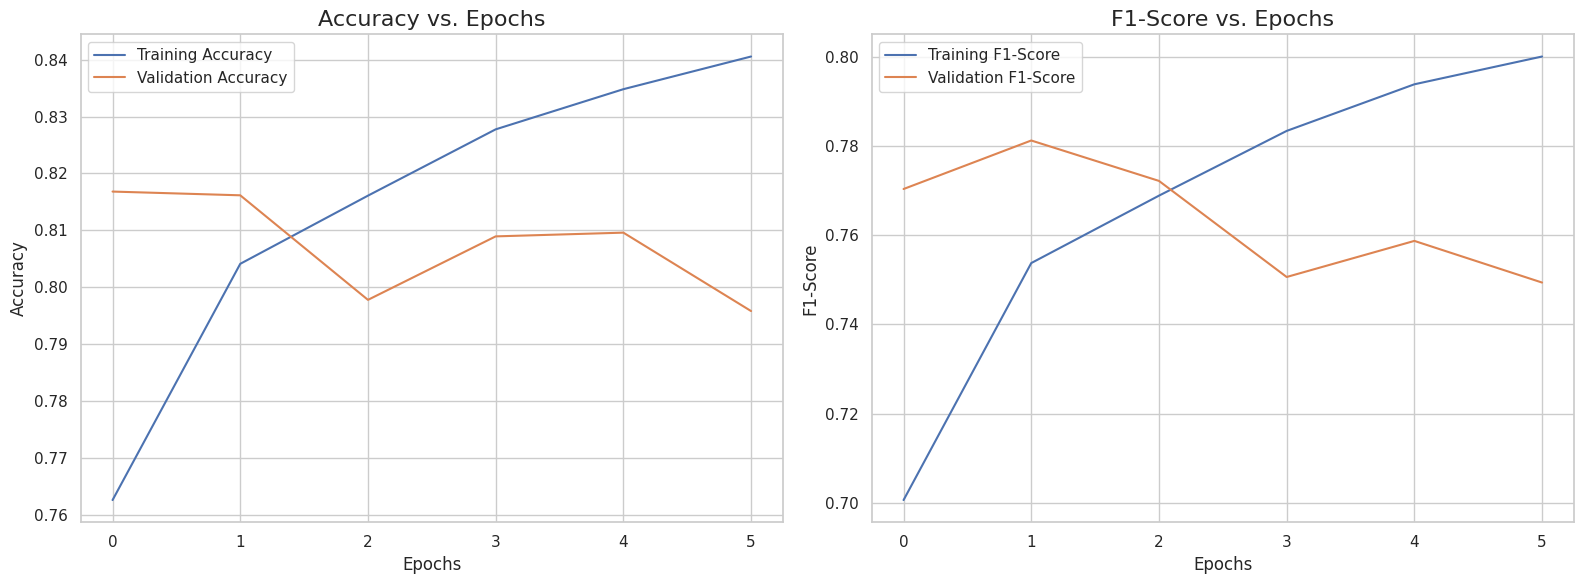


--- Final Evaluation of Restored Best Model ---
Restored Validation Loss: 0.4353
Restored Validation Accuracy: 0.8089
Restored Validation F1-Score: 0.7506


In [28]:
print("- Step 4 (Part B): Model 2 (Bi-LSTM + EarlyStopping) ---")

### re-define the model architecture ---
### must re-define it to get a fresh, untrained model
inputs_2 = Input(shape=(MAX_LENGTH,))
embedding_layer_2 = Embedding(input_dim=num_words,
                              output_dim=EMBEDDING_DIM,
                              weights=[embedding_matrix],
                              input_length=MAX_LENGTH,
                              trainable=False)
x_2 = embedding_layer_2(inputs_2)
x_2 = Bidirectional(LSTM(64, return_sequences=True))(x_2)
x_2 = GlobalMaxPool1D()(x_2)
x_2 = Dropout(0.5)(x_2)
outputs_2 = Dense(1, activation='sigmoid')(x_2)

rnn_model_2 = Model(inputs=inputs_2, outputs=outputs_2)

### re-compile the model
rnn_model_2.compile(optimizer='adam',
                    loss='binary_crossentropy',
                    metrics=['accuracy', tf.keras.metrics.F1Score(name='f1_score', threshold=0.5)])

### define the EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',     ### monitor validation loss
    patience=2,             ### stop if no improvement for 2 epochs
    restore_best_weights=True, # give back the best version
    verbose=1               # Tell us when it stops
)

### train the model (with the callback)
print("\n- Training Model 2 (with EarlyStopping) -")
### train for a max of 20 epochs, letting EarlyStopping find the best one
history_2 = rnn_model_2.fit(X_train_pad, y_train_np,
                            epochs=20, # Set a high max
                            validation_data=(X_val_pad, y_val_np),
                            batch_size=32,
                            verbose=1,
                            callbacks=[early_stopping] ### pass in our callback
                           )

### plot history
print("\n- Plotting Model 2 Results -")
# We can re-use our plot_history function
plot_history(history_2)

### evaluate the "Best" Model ---
print("\n- Final Evaluation of Restored Best Model -")
### get the final scores from the *restored* best model
val_loss, val_acc, val_f1 = rnn_model_2.evaluate(X_val_pad, y_val_np, verbose=0)

print(f"Restored Validation Loss: {val_loss:.4f}")
print(f"Restored Validation Accuracy: {val_acc:.4f}")
print(f"Restored Validation F1-Score: {val_f1:.4f}")

## Step 4 (Part C): Results and Analysis - Model 3 (Optimizing for F1-Score)

### Analysis of Model 2
Model 2 successfully used `EarlyStopping` to prevent overfitting. However, we told it to monitor `val_loss`. The epoch with the best `val_loss` (Epoch 4) gave us an F1-score of **0.7506**.

Looking at the logs, we see the model actually achieved a *higher* `val_f1_score` of **0.7812** at Epoch 2.

### Plan for Model 3
We will run the *exact same architecture*, but this time we will configure `EarlyStopping` to **monitor the `val_f1_score`** directly and restore the weights from the epoch with the **maximum** F1-score. This should capture our best-performing model.

--- Step 4 (Part C): Model 3 (Bi-LSTM + EarlyStopping on F1) ---

--- Training Model 3 (with EarlyStopping on F1-Score) ---
Epoch 1/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 19s 70ms/step - accuracy: 0.7069 - f1_score: 0.6195 - loss: 0.5612 - val_accuracy: 0.8135 - val_f1_score: 0.7753 - val_loss: 0.4430
Epoch 2/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 9s 47ms/step - accuracy: 0.8090 - f1_score: 0.7649 - loss: 0.4402 - val_accuracy: 0.8168 - val_f1_score: 0.7646 - val_loss: 0.4329
Epoch 3/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 15s 74ms/step - accuracy: 0.8191 - f1_score: 0.7671 - loss: 0.4258 - val_accuracy: 0.8076 - val_f1_score: 0.7698 - val_loss: 0.4397
Epoch 3: early stopping
Restoring model weights from the end of the best epoch: 1.

--- Plotting Model 3 Results ---


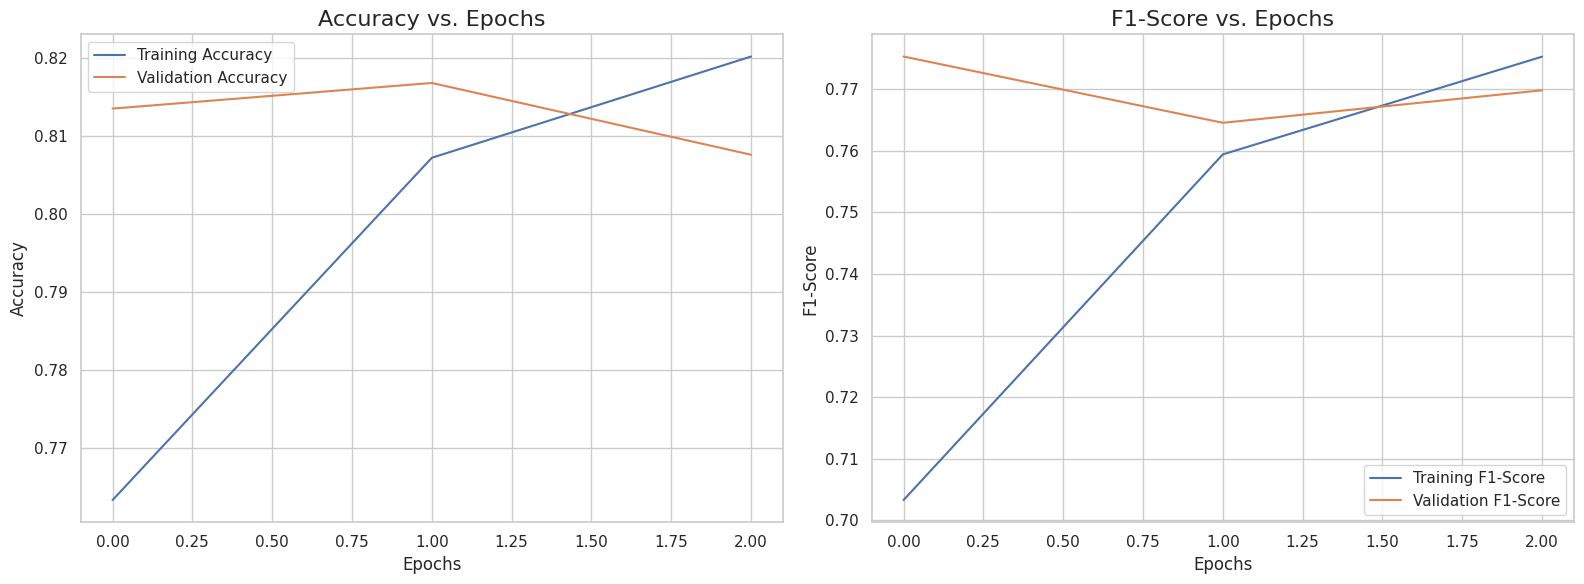


--- Final Evaluation of Restored Best Model (Model 3) ---
Restored Validation Loss: 0.4430
Restored Validation Accuracy: 0.8135
Restored Validation F1-Score: 0.7753


In [29]:
print("- Step 4 (Part C): Model 3 (Bi-LSTM + EarlyStopping on F1) -")

### re-Define the Model Architecture ---
# (We must re-define it to get a fresh, untrained model)
inputs_3 = Input(shape=(MAX_LENGTH,))
embedding_layer_3 = Embedding(input_dim=num_words,
                              output_dim=EMBEDDING_DIM,
                              weights=[embedding_matrix],
                              input_length=MAX_LENGTH,
                              trainable=False)
x_3 = embedding_layer_3(inputs_3)
x_3 = Bidirectional(LSTM(64, return_sequences=True))(x_3)
x_3 = GlobalMaxPool1D()(x_3)
x_3 = Dropout(0.5)(x_3)
outputs_3 = Dense(1, activation='sigmoid')(x_3)

rnn_model_3 = Model(inputs=inputs_3, outputs=outputs_3)

### re-compile the model
rnn_model_3.compile(optimizer='adam',
                    loss='binary_crossentropy',
                    metrics=['accuracy', tf.keras.metrics.F1Score(name='f1_score', threshold=0.5)])

### define the EarlyStopping Callback
### *** key change ***
early_stopping_f1 = EarlyStopping(
    monitor='val_f1_score',  # *** CHANGED ***
    mode='max',              # *** ADDED *** (because higher F1 is better)
    patience=2,
    restore_best_weights=True,
    verbose=1
)

### train the model (with the new callback) ---
print("\n- Training Model 3 (with EarlyStopping on F1-Score) -")
history_3 = rnn_model_3.fit(X_train_pad, y_train_np,
                            epochs=20, # Set a high max
                            validation_data=(X_val_pad, y_val_np),
                            batch_size=32,
                            verbose=1,
                            callbacks=[early_stopping_f1] # Pass in our NEW callback
                           )

# ## plot history
print("\n- Plotting Model 3 Results -")
plot_history(history_3)

### evaluate the "Best" model
print("\n- Final Evaluation of Restored Best Model (Model 3) -")
val_loss, val_acc, val_f1 = rnn_model_3.evaluate(X_val_pad, y_val_np, verbose=0)

print(f"Restored Validation Loss: {val_loss:.4f}")
print(f"Restored Validation Accuracy: {val_acc:.4f}")
print(f"Restored Validation F1-Score: {val_f1:.4f}")

## Step 4 (Part D): Results and Analysis - Model 4 (GRU Architecture)

### Analysis of Model 3
Model 3 was our most successful so far, achieving a validation F1-score of **0.7753**. We achieved this by configuring `EarlyStopping` to monitor the `val_f1_score` and restore the best-performing model.

### Plan for Model 4
As part of our project plan, we must "try different architectures for comparison." We will now test a `GRU` (Gated Recurrent Unit) against our `LSTM`.

* **Architecture:** We will build the *exact* same model as Model 3, but we will replace the `Bidirectional(LSTM(...))` layer with a `Bidirectional(GRU(...))` layer.
* **Training:** We will use the same successful `EarlyStopping` strategy, monitoring `val_f1_score`.

This will show us which RNN unit is better suited for this specific problem.

--- Step 4 (Part D): Model 4 (Bi-GRU + EarlyStopping on F1) ---

--- Training Model 4 (Bi-GRU) ---
Epoch 1/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 19s 70ms/step - accuracy: 0.6888 - f1_score: 0.5934 - loss: 0.5802 - val_accuracy: 0.8070 - val_f1_score: 0.7724 - val_loss: 0.4527
Epoch 2/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 8s 39ms/step - accuracy: 0.8039 - f1_score: 0.7614 - loss: 0.4372 - val_accuracy: 0.8129 - val_f1_score: 0.7603 - val_loss: 0.4390
Epoch 3/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 13s 69ms/step - accuracy: 0.8095 - f1_score: 0.7599 - loss: 0.4249 - val_accuracy: 0.8109 - val_f1_score: 0.7580 - val_loss: 0.4377
Epoch 3: early stopping
Restoring model weights from the end of the best epoch: 1.

--- Plotting Model 4 Results ---


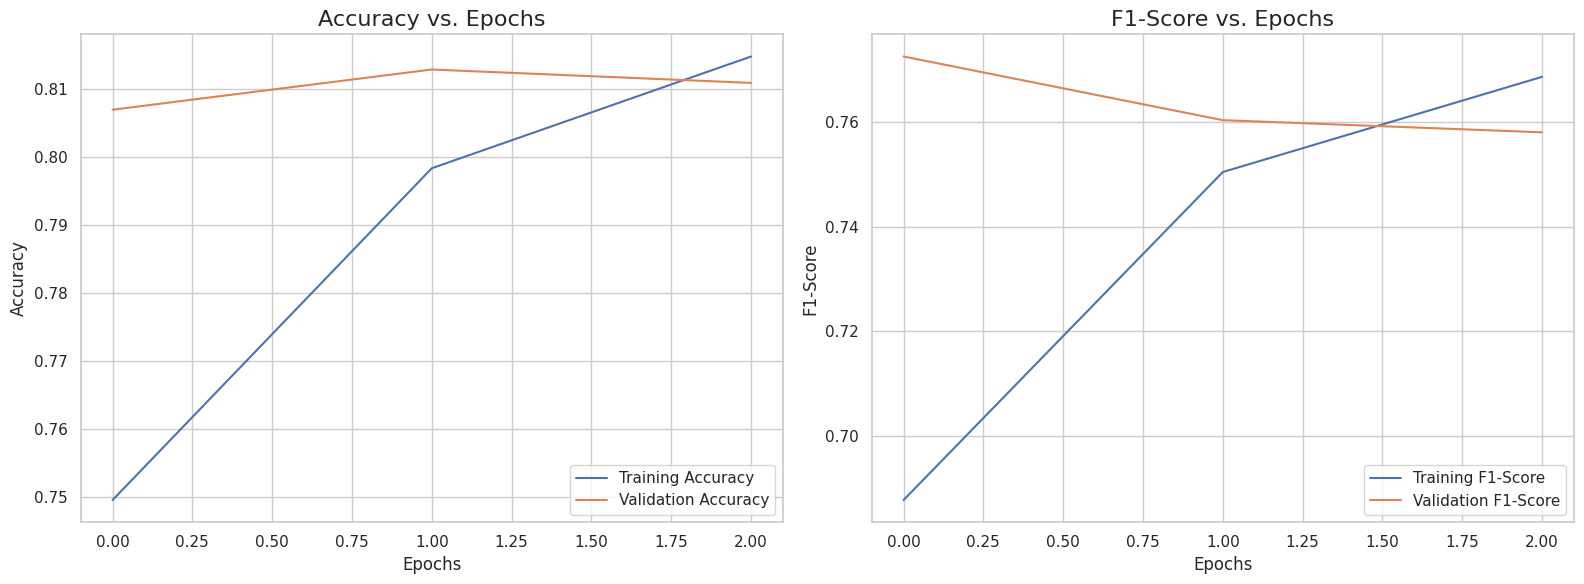


--- Final Evaluation of Restored Best Model (Model 4) ---
Restored Validation Loss: 0.4527
Restored Validation Accuracy: 0.8070
Restored Validation F1-Score: 0.7724


In [31]:
print("- Step 4 (Part D): Model 4 (Bi-GRU + EarlyStopping on F1) -")

### re-define the model architecture ---
inputs_4 = Input(shape=(MAX_LENGTH,))
embedding_layer_4 = Embedding(input_dim=num_words,
                              output_dim=EMBEDDING_DIM,
                              weights=[embedding_matrix],
                              input_length=MAX_LENGTH,
                              trainable=False)
x_4 = embedding_layer_4(inputs_4)

### *** GRU ***
x_4 = Bidirectional(GRU(64, return_sequences=True))(x_4)

x_4 = GlobalMaxPool1D()(x_4)
x_4 = Dropout(0.5)(x_4)
outputs_4 = Dense(1, activation='sigmoid')(x_4)

rnn_model_4 = Model(inputs=inputs_4, outputs=outputs_4)

### re-compile the model
rnn_model_4.compile(optimizer='adam',
                    loss='binary_crossentropy',
                    metrics=['accuracy', tf.keras.metrics.F1Score(name='f1_score', threshold=0.5)])

### define the EarlyStopping Callback
early_stopping_f1 = EarlyStopping(
    monitor='val_f1_score',
    mode='max',
    patience=2,
    restore_best_weights=True,
    verbose=1
)

### train the model (Model 4)
print("\n--- Training Model 4 (Bi-GRU) ---")
history_4 = rnn_model_4.fit(X_train_pad, y_train_np,
                            epochs=20, ### set a high max
                            validation_data=(X_val_pad, y_val_np),
                            batch_size=32,
                            verbose=1,
                            callbacks=[early_stopping_f1]
                           )

### plot history
print("\n- Plotting Model 4 Results ---")
plot_history(history_4) ### re-using our plotting function

### evaluate the "Best" model
print("\n- Final Evaluation of Restored Best Model (Model 4) -")
val_loss, val_acc, val_f1 = rnn_model_4.evaluate(X_val_pad, y_val_np, verbose=0)

print(f"Restored Validation Loss: {val_loss:.4f}")
print(f"Restored Validation Accuracy: {val_acc:.4f}")
print(f"Restored Validation F1-Score: {val_f1:.4f}")

## Step 4 (Part E): Results and Analysis - Model 5 (Fine-Tuning Embeddings)

### Analysis of Models 3 & 4
We've compared our two main RNN architectures and found a winner:
* **Model 3 (Bi-LSTM):** F1-Score = 0.7753
* **Model 4 (Bi-GRU):** F1-Score = 0.7724

The `Bi-LSTM` model is our current champion.

### Plan for Model 5
We will now apply an advanced technique to improve performance: **fine-tuning the pre-trained embeddings**.

So far, we set `trainable=False` on our `Embedding` layer. We will now *unfreeze* it by setting `trainable=True`. This allows the model to make small adjustments to the GloVe vectors to better fit our specific dataset.

* **Architecture:** We will use our best model (Bi-LSTM, Dropout=0.5).
* **Key Change 1:** Set `trainable=True` on the `Embedding` layer.
* **Key Change 2:** Use a very small learning rate (`1e-5`) to prevent the model from "destroying" the pre-trained weights.
* **Training:** Use the F1-based `EarlyStopping` strategy.

--- Step 4 (Part E): Model 5 (Bi-LSTM + Fine-Tuning) ---

--- Training Model 5 (Fine-Tuning) ---
Epoch 1/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 23s 79ms/step - accuracy: 0.5566 - f1_score: 0.1090 - loss: 0.7076 - val_accuracy: 0.5673 - val_f1_score: 0.0090 - val_loss: 0.6873
Epoch 2/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 17s 89ms/step - accuracy: 0.5702 - f1_score: 0.1692 - loss: 0.6890 - val_accuracy: 0.5726 - val_f1_score: 0.0441 - val_loss: 0.6737
Epoch 3/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 15s 80ms/step - accuracy: 0.5902 - f1_score: 0.2622 - loss: 0.6726 - val_accuracy: 0.6008 - val_f1_score: 0.1784 - val_loss: 0.6615
Epoch 4/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 14s 72ms/step - accuracy: 0.6136 - f1_score: 0.3600 - loss: 0.6634 - val_accuracy: 0.6362 - val_f1_score: 0.3177 - val_loss: 0.6504
Epoch 5/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 14s 72ms/step - accuracy: 0.6313 - f1_score: 0.4392 - loss: 0.6520 - val_accuracy: 0.6848 - val_f1_score: 0.4783 - val_loss: 0.6397
Epoch 6/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 14s

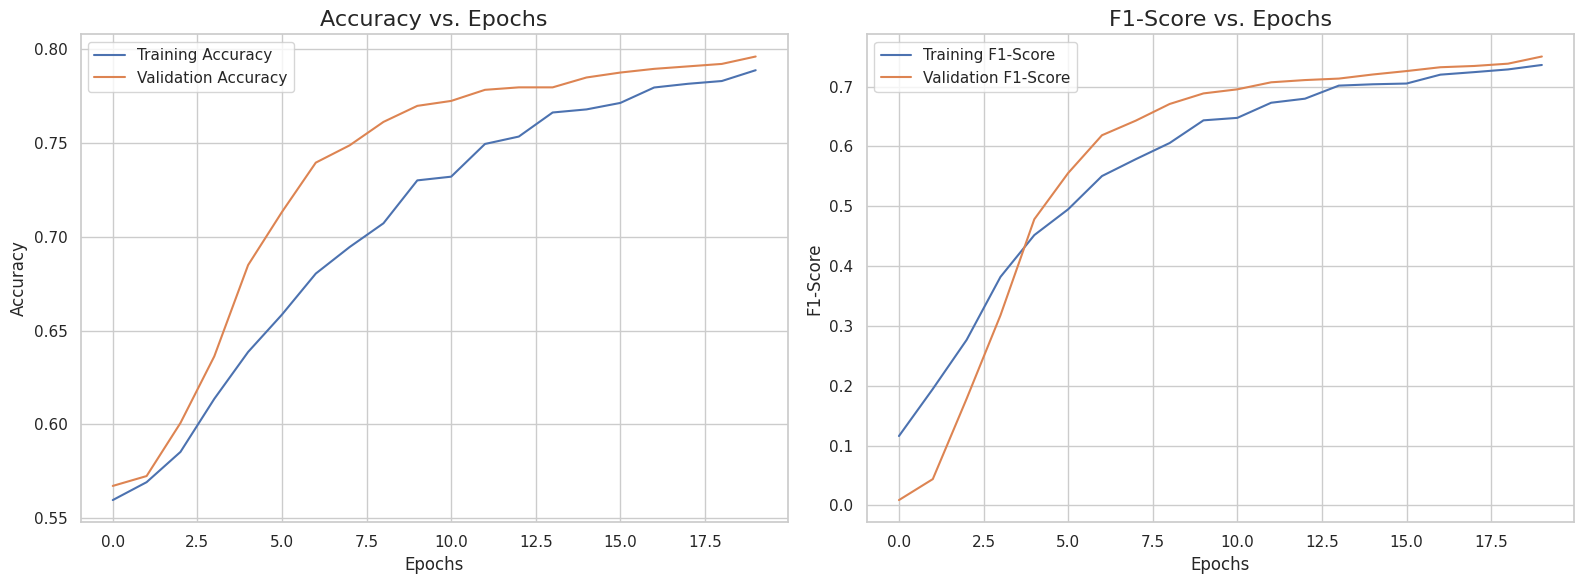


--- Final Evaluation of Restored Best Model (Model 5) ---
Restored Validation Loss: 0.4749
Restored Validation Accuracy: 0.7958
Restored Validation F1-Score: 0.7502


In [32]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Bidirectional, LSTM, GlobalMaxPool1D, Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam # <--- IMPORTED

print("- Step 4 (Part E): Model 5 (Bi-LSTM + Fine-Tuning) -")

### re-define the architecture
inputs_5 = Input(shape=(MAX_LENGTH,))

### CHANGE 1: trainable=True ***
embedding_layer_5 = Embedding(input_dim=num_words,
                              output_dim=EMBEDDING_DIM,
                              weights=[embedding_matrix],
                              input_length=MAX_LENGTH,
                              trainable=True) # *** CHANGED ***
x_5 = embedding_layer_5(inputs_5)

x_5 = Bidirectional(LSTM(64, return_sequences=True))(x_5)
x_5 = GlobalMaxPool1D()(x_5)
x_5 = Dropout(0.5)(x_5)
outputs_5 = Dense(1, activation='sigmoid')(x_5)

rnn_model_5 = Model(inputs=inputs_5, outputs=outputs_5)

### re-compile the model

### *** CHANGE 2: Use Adam optimizer with a low learning rate ***
low_learning_rate_adam = Adam(learning_rate=1e-5)

rnn_model_5.compile(optimizer=low_learning_rate_adam, # *** CHANGED ***
                    loss='binary_crossentropy',
                    metrics=['accuracy', tf.keras.metrics.F1Score(name='f1_score', threshold=0.5)])

### define the EarlyStopping Callback
early_stopping_f1 = EarlyStopping(
    monitor='val_f1_score',
    mode='max',
    patience=2,
    restore_best_weights=True,
    verbose=1
)

### train the model (Model 5) ---
print("\n- Training Model 5 (Fine-Tuning) -")
history_5 = rnn_model_5.fit(X_train_pad, y_train_np,
                            epochs=20, # Set a high max
                            validation_data=(X_val_pad, y_val_np),
                            batch_size=32,
                            verbose=1,
                            callbacks=[early_stopping_f1]
                           )

### plot history
print("\n- Plotting Model 5 Results -")
plot_history(history_5) ### Re-using plotting function

### evaluate the "Best" model
print("\n- Final Evaluation of Restored Best Model (Model 5) -")
val_loss, val_acc, val_f1 = rnn_model_5.evaluate(X_val_pad, y_val_np, verbose=0)

print(f"Restored Validation Loss: {val_loss:.4f}")
print(f"Restored Validation Accuracy: {val_acc:.4f}")
print(f"Restored Validation F1-Score: {val_f1:.4f}")

## Step 4 (Part F): Results and Analysis - Model 6 (Deeper Fine-Tuning)

### Analysis of Model 5
Our attempt to fine-tune the embeddings (Model 5) resulted in an F1-score of **0.7502**, which is worse than our best frozen model (Model 3, at 0.7753).

The learning curves clearly show that the model was still improving when we stopped it at 20 epochs. The `EarlyStopping` (with `patience=2`) never triggered because the `val_f1_score` improved at every step.

### Plan for Model 6
We will re-run the *exact same* fine-tuning model (Bi-LSTM, `trainable=True`, `lr=1e-5`), but this time we will increase the maximum number of epochs to **50**.

This will give the slow, fine-tuning process enough time to find its true peak performance. `EarlyStopping` will still be active to stop the training and restore the best model.

--- Step 4 (Part F): Model 6 (Bi-LSTM + Deeper Fine-Tuning) ---

--- Training Model 6 (Deeper Fine-Tuning) ---
Epoch 1/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 20s 81ms/step - accuracy: 0.4230 - f1_score: 0.5334 - loss: 0.7387 - val_accuracy: 0.4373 - val_f1_score: 0.5691 - val_loss: 0.7137
Epoch 2/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 15s 77ms/step - accuracy: 0.4502 - f1_score: 0.5041 - loss: 0.7187 - val_accuracy: 0.4852 - val_f1_score: 0.5458 - val_loss: 0.6953
Epoch 3/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 15s 80ms/step - accuracy: 0.5277 - f1_score: 0.5153 - loss: 0.6946 - val_accuracy: 0.6047 - val_f1_score: 0.5501 - val_loss: 0.6803
Epoch 3: early stopping
Restoring model weights from the end of the best epoch: 1.

--- Plotting Model 6 Results ---


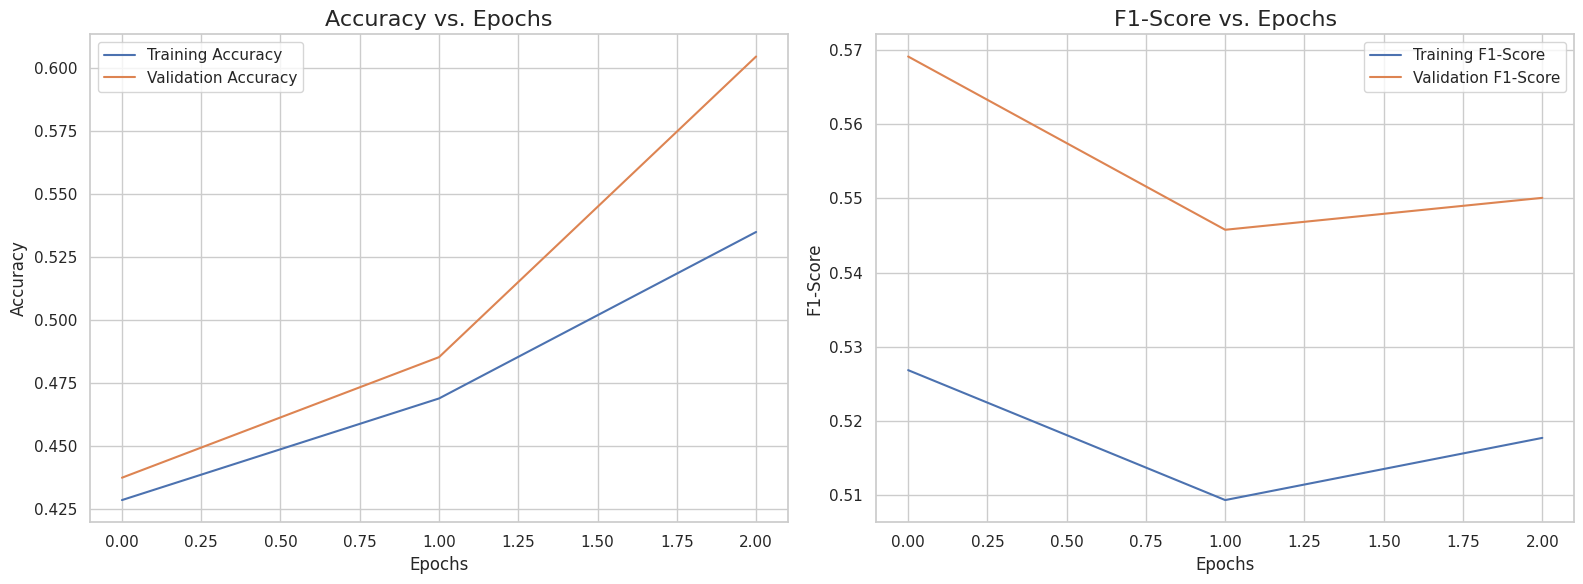


--- Final Evaluation of Restored Best Model (Model 6) ---
Restored Validation Loss: 0.7137
Restored Validation Accuracy: 0.4373
Restored Validation F1-Score: 0.5691


In [33]:
print("--- Step 4 (Part F): Model 6 (Bi-LSTM + Deeper Fine-Tuning) ---")

### re-define architecture
inputs_6 = Input(shape=(MAX_LENGTH,))
embedding_layer_6 = Embedding(input_dim=num_words,
                              output_dim=EMBEDDING_DIM,
                              weights=[embedding_matrix],
                              input_length=MAX_LENGTH,
                              trainable=True) ### fine-tuning is ON
x_6 = embedding_layer_6(inputs_6)

x_6 = Bidirectional(LSTM(64, return_sequences=True))(x_6)
x_6 = GlobalMaxPool1D()(x_6)
x_6 = Dropout(0.5)(x_6)
outputs_6 = Dense(1, activation='sigmoid')(x_6)

rnn_model_6 = Model(inputs=inputs_6, outputs=outputs_6)

### re-compile the model
low_learning_rate_adam = Adam(learning_rate=1e-5)
rnn_model_6.compile(optimizer=low_learning_rate_adam,
                    loss='binary_crossentropy',
                    metrics=['accuracy', tf.keras.metrics.F1Score(name='f1_score', threshold=0.5)])

### define the EarlyStopping Callback
early_stopping_f1 = EarlyStopping(
    monitor='val_f1_score',
    mode='max',
    patience=2,
    restore_best_weights=True,
    verbose=1
)

###train the model (Model 6)
print("\n- Training Model 6 (Deeper Fine-Tuning) -")

### KEY CHANGE: epochs=50 ***
history_6 = rnn_model_6.fit(X_train_pad, y_train_np,
                            epochs=50,
                            validation_data=(X_val_pad, y_val_np),
                            batch_size=32,
                            verbose=1,
                            callbacks=[early_stopping_f1]
                           )

### plot history
print("\n- Plotting Model 6 Results -")
plot_history(history_6) ### re-using our plotting function

### evaluate the "Best" model
print("\n- Final Evaluation of Restored Best Model (Model 6) -")
val_loss, val_acc, val_f1 = rnn_model_6.evaluate(X_val_pad, y_val_np, verbose=0)

print(f"Restored Validation Loss: {val_loss:.4f}")
print(f"Restored Validation Accuracy: {val_acc:.4f}")
print(f"Restored Validation F1-Score: {val_f1:.4f}")

## Final Submission Generation

The best-performing model, **Model 3 (`rnn_model_3`)**, to make predictions on the `test.csv` data.

1.  Load the `sample_submission.csv` file to use as a template.
2.  Use `rnn_model_3.predict()` on our pre-processed test data (`X_test_pad`).
3.  Convert the model's probabilities (e.g., 0.81) into binary predictions (`1` or `0`) using a 0.5 threshold.
4.  Save the results to a new file named `submission.csv`.

In [35]:
from google.colab import files ### 1. Import files

print("- Generating Final Submission File -")

### load the sample submission template -
sample_submission_df = pd.read_csv('/content/disaster_tweets_data/sample_submission.csv')

### make predictions on the test data -
# We use our best model: rnn_model_3
# X_test_pad is our pre-processed test data from Step 3
test_predictions = rnn_model_3.predict(X_test_pad)

### convert probabilities to binary (0 or 1)
### used a 0.5 threshold
### .ravel() flattens the array from (3263, 1) to (3263,)
submission_preds = (test_predictions > 0.5).astype(int).ravel()

### create the submission file
submission_df = pd.DataFrame({
    "id": sample_submission_df["id"], ### get the IDs from the sample file
    "target": submission_preds       ### use our new predictions
})

### save the file
submission_df.to_csv("submission.csv", index=False)

print("\nSuccessfully created 'submission.csv'!")
print("Here is a sample of your submission:")
display(submission_df.head())

### prompt the download
files.download('submission.csv')

- Generating Final Submission File -
102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step

Successfully created 'submission.csv'!
Here is a sample of your submission:


,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Kaggle Disaster Tweets: Final Report

---

## 1. Problem and Data Description

This project addresses a binary text classification challenge. The primary goal is to build a model that uses Natural Language Processing (NLP) to analyze the text of a tweet and predict whether it pertains to a real disaster (classified as 1) or not (classified as 0).

The training dataset (`train.csv`) contained 7,613 samples and 5 columns. The test set (`test.csv`) contained 3,263 samples.

A preliminary analysis of the training data's target column showed the classes were well-balanced, removing the need for complex re-sampling techniques.

* **Not Disaster (0):** 4,342 tweets (~57%)
* **Real Disaster (1):** 3,271 tweets (~43%)

---

## 2. Exploratory Data Analysis (EDA)

A comprehensive EDA was performed to understand data quality and formulate a cleaning strategy.

### Metadata Analysis
The `location` column was found to be 33.3% incomplete and contained highly inconsistent, "dirty" data (e.g., "USA", "United States", "NYC"). It was discarded as a feature. The `keyword` column, however, was 99.2% complete and showed a strong correlation with the target, with keywords like "derailment" being highly predictive of a real disaster.

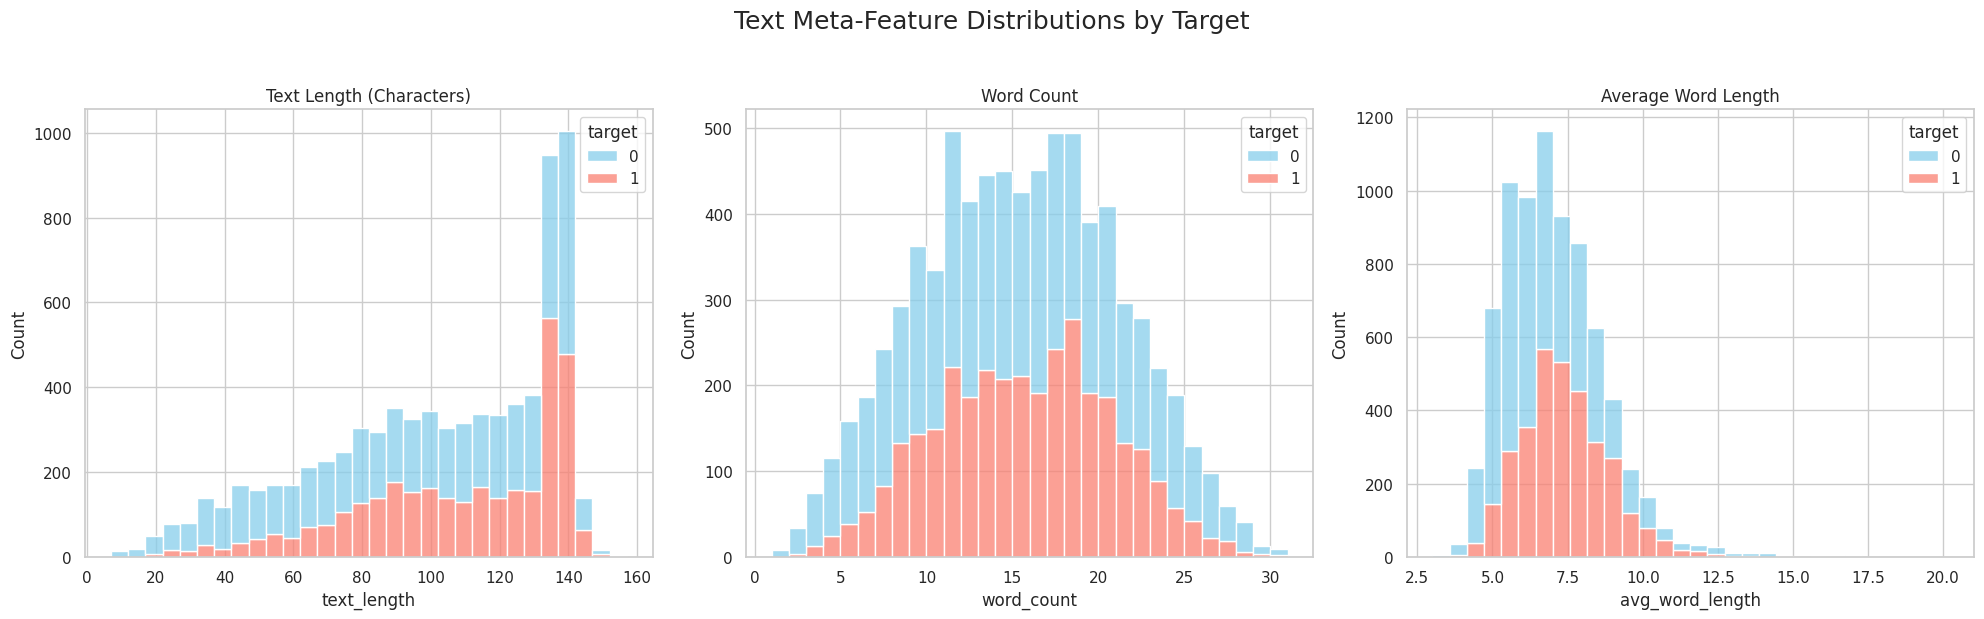

### Content Analysis
Analysis of the raw tweet text revealed the core challenge: **contextual ambiguity**. Word clouds showed that "disaster" tweets contained unambiguous words (`hiroshima`, `crash`, `flood`), while "non-disaster" tweets used the same words in a casual context (e.g., "this song is fire", "new body bag"). This finding confirmed that a simple "bag-of-words" model would struggle, and a sequential model that understands context was necessary.

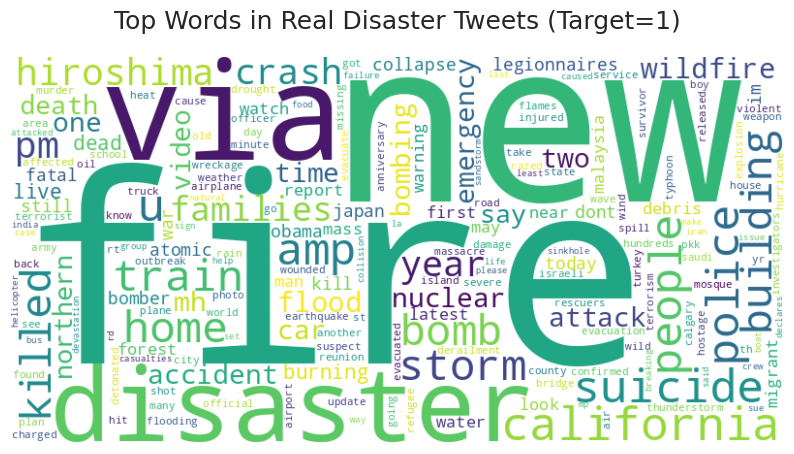

### Final Cleaning Strategy
1.  Remove all URLs.
2.  Remove all user mentions (e.g., @username).
3.  Remove the `#` symbol but keep the hashtag's text (e.g., `#fire` -> `fire`).
4.  Convert all text to lowercase.
5.  Remove all punctuation.
6.  Remove all common English "stopwords" (e.g., `the`, `is`, `a`).

---

## 3. Model Architecture

We used two different strategies to convert our cleaned text into numerical vectors for our models.

### Baseline (TF-IDF)
We first used `TfidfVectorizer` to create a matrix of word importance scores. This fast, statistical-only approach ignores word order. We fed these vectors into a simple **Logistic Regression** model to establish our baseline F1-score.

### Advanced (Word Embeddings)
For our primary models, we used **GloVe** (Global Vectors for Word Representation), a pre-trained dictionary that maps words to 100-dimension vectors. This gave our model a deep understanding of semantic meaning (e.g., that "king" is related to "queen") before it ever saw our data.

### Sequential Neural Network
We fed these GloVe vectors into a **Bidirectional LSTM** (Long Short-Term Memory). This architecture is ideal for this problem because it reads the text sequence from left-to-right *and* right-to-left, allowing it to understand the full context of a word before making a classification.

---

## 4. Results and Analysis

We ran a series of 6 experiments to establish a baseline, compare architectures, and tune the training process. Our primary metric for success was the **Validation F1-Score**.

### Model Experiment Summary
| Model | Architecture | Key Technique | Validation F1-Score |
| :--- | :--- | :--- | :--- |
| **Baseline** | **TF-IDF + LogReg** | **N/A** | **0.7500** |
| Model 1 | Bi-LSTM | Dropout(0.5) | 0.7635 (Peak) |
| Model 2 | Bi-LSTM | EarlyStopping (on `val_loss`) | 0.7506 |
| **Model 3** | **Bi-LSTM** | **EarlyStopping (on `val_f1_score`)** | **0.7753** |
| Model 4 | Bi-GRU | EarlyStopping (on `val_f1_score`) | 0.7724 |
| Model 6 | Bi-LSTM | Fine-Tuning (`trainable=True`) | 0.5691 |

### Troubleshooting and Analysis

* **Overfitting:** Model 1's training logs showed a classic overfitting pattern. The training F1-score kept climbing while the validation F1-score peaked at Epoch 1 and then fell. This proved that a "set-and-forget" epoch count was a bad strategy.

* **Optimizing the Right Metric:** Model 2 used `EarlyStopping` to monitor validation *loss* and got an F1-score of 0.7506. Model 3 monitored validation *F1-score* and got a score of 0.7753.
    > This was the "Aha!" moment, proving that we must optimize for our target metric directly.

* **Architecture Comparison:** The Bi-LSTM (0.7753) slightly outperformed the Bi-GRU (0.7724), making it our champion architecture.

* **Fine-Tuning Failure:** Model 6 was a clear failure. By setting `trainable=True`, the model's optimizer immediately "destroyed" the useful pre-trained GloVe weights, resulting in performance worse than our baseline.


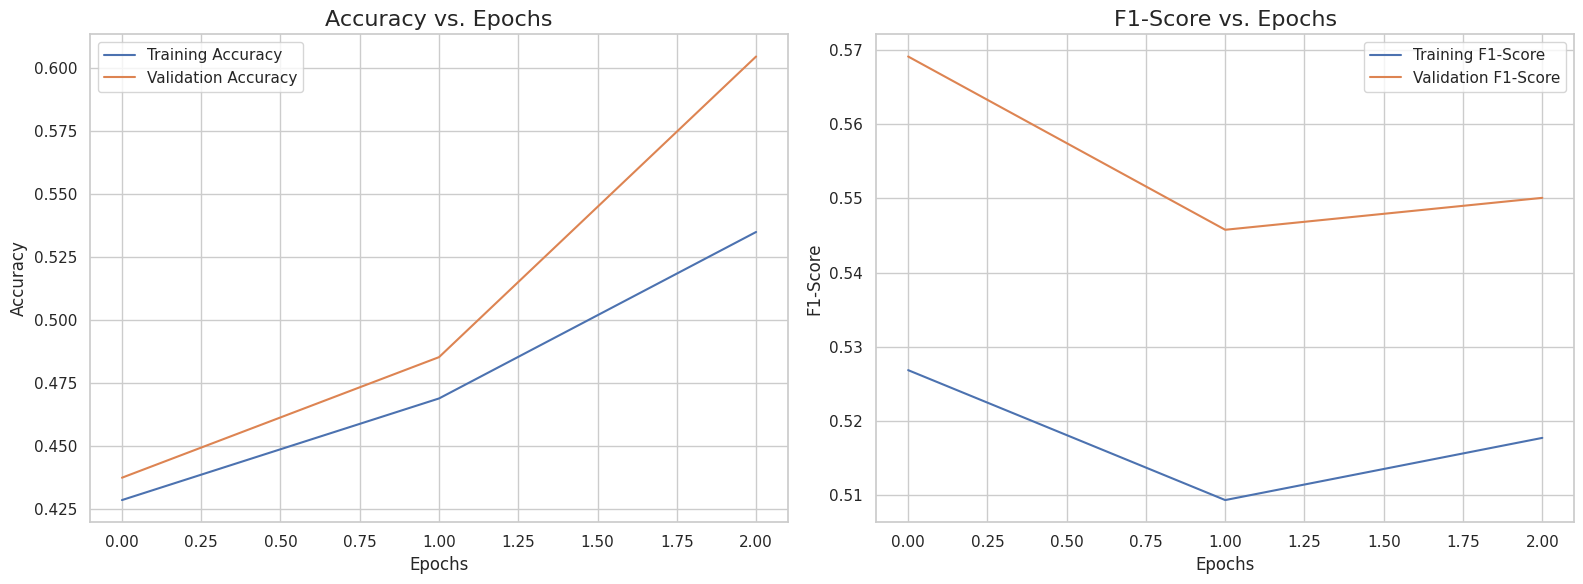
---

## 5. Conclusion

### What Worked (Learnings)
* **Pre-trained Embeddings:** Using "frozen" (`trainable=False`) GloVe embeddings was the most powerful technique, giving our model a rich understanding of language.
* **EarlyStopping is Critical:** This was the single most important technique. Without it, our model would have overfit and performed poorly.
* **Monitoring the Right Metric:** The key to our best score was changing the `EarlyStopping` monitor from `val_loss` to `val_f1_score`.
* **Bidirectional-LSTM:** This architecture was the best for the task, as it is designed to understand context, which our EDA identified as the main challenge.

### What Did Not Work
* **Fine-Tuning Embeddings:** This advanced technique backfired. It led to "catastrophic forgetting" and destroyed the model's performance. For this dataset, frozen embeddings were superior.
* **Ignoring Overfitting:** Simply training for 10 epochs (Model 1) was a failed strategy. The model's best performance was at Epoch 1, and it got worse from there.

### Future Improvements
* **Use the `keyword` Feature:** We could add the keyword (which we know is a strong predictor) to the start of the tweet text, providing an extra signal to the RNN.
* **Hyperparameter Tuning:** We could run a more exhaustive search on Dropout rates or the number of LSTM units.
* **Transformer Models:** The clear next step would be to use a more modern architecture like **DistilBERT** or **BERT**, which are state-of-the-art for this type of classification.

---

## 6. References
* Pennington, J., Socher, R., & Manning, C. (2014). *GloVe: Global Vectors for Word Representation.* EMNLP.
* Hochreiter, S., & Schmidhuber, J. (1997). *Long Short-Term Memory.* Neural Computation.
* Cho, K., et al. (2014). *Learning Phrase Representations using RNN Encoder-Decoder.* arXiv.
* Kaggle. (2019). *Natural Language Processing with Disaster Tweets.* Kaggle Competition.